# Sentiment Analysis Using Twitter API "Tweepy"

This project is the pre-cursor to a Sentiment Analysis-enabled RoboAdvisor to be created using AWS Lex, Lambda, Comprehend and SageMaker. Here, the basic Sentiment Analysis functionality has been built, implementing NLTK and TextBlob NLP libraries and the Twitter API, Teepy. This will be expanded to additonally implement IBM Watson NLU, AWS Comprehend and VADER (Valence Aware Dictionary and sEntiment Reasoner), and will scrape text from other sites, such as Reddit and Google Trends. The code for these additonal functionalities has been completed, but has been separated into other notebooks until the next version of the app is developed. The CLI of this app will later become a bot...

This code allows one to analyze sentiment around a topic of choice using tweets. PieChart and WordCloud visualizations are generated, as well as ngram models that provide the user with a glance at which words are most used and which words are used together.


## Notes on Installations and Libraries:

Tweepy, the Twitter API supports both OAuth 1a (application-user) and OAuth 2 (application-only) authentication. Authentication is handled by the tweepy.AuthHandler class. OAuth 2 is a method of authentication where an application makes API requests without the user context. Use this method if you just need read-only access to public information.

**You need to have a Twitter Developer Account before authorizations!**

**TextBlob** is a Python (2 and 3) library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more.

**NLTK** is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries.


## What is Sentiment Analysis?

Sentiment Analysis is the process of computationally determining whether a piece of writing is positive, negative, or neutral. It is also known as **"opinion mining"**, deriving the opinion or attitude of a speaker.

## Install and Import Libraries

In [1]:
# Install Libraries
!pip install textblob
!pip install tweepy

In [2]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt #to display our wordcloud
import pandas as pd
import numpy as np #to get the color of our image
import os
import nltk
import pycountry
import re
import string
from dotenv import load_dotenv
import requests
import json

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image #to load out image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruhhhhhh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load .env environment variables
load_dotenv()

Python-dotenv could not parse statement starting at line 25
Python-dotenv could not parse statement starting at line 28
Python-dotenv could not parse statement starting at line 29


True

## Tweepy Authentication

In [4]:
# Authentication
consumerKey = os.getenv("TWITTER_API_KEY")
consumerSecret = os.getenv("TWITTER_SECRET_KEY")
accessToken = os.getenv("TWITTER_ACCESS_TOKEN")
accessTokenSecret = os.getenv("TWITTER_ACCESS_TOKEN_SECRET")

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

## Fetching Tweets by Hashtag or Keyword

Use **Tweepy** to fetch text (tweets), then use TextBlob to calculate positive, negative, neutral, polarity and compound parameters from the text.
The user types into the CLI the keyword or hashtag and the number of tweets they want to analyze.

In [5]:
# Setting Up, basic Sentiment Analysis review
def percentage(part,whole):
    return 100 * float(part)/float(whole) 

keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))


tweets = tweepy.Cursor(api.search_tweets, q=keyword).items(noOfTweet)
positive  = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets:
    
    #print(tweet.text)
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1

    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Please enter keyword or hashtag to search:  solana
Please enter how many tweets to analyze:  500


### Viewing a breakdown of the tweets by Sentiment Category

In [6]:
# Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  500
positive number:  361
negative number:  20
neutral number:  119


In [7]:
# Review the Tweets DataFrame
tweet_list

,0
0,@Sol_Hachiko @SirBuddy6 \n@Olivet1199 \n@Delig...
1,RT @Puppy_Solana: 🐶 To celebrate our launch on...
2,@joscarly303 https://t.co/zpJ8w818qh is First ...
3,"Check @shibafamily_nft, 2nd sale from Shiba Fa..."
4,@kitty_solana Good project sir @Ilhamarifsetiy...
...,...
495,"RT @degencoinsol: We are giving 1,000,000 #DEG..."
496,RT @solchampions: WE ARE LIVE BOYS! SUMMON YOU...
497,RT @Tepeecrew: They are coming… 🔥🔥🔥 Are you re...
498,RT @tylerposey627: @solanaDoggy @aj_timi \n@iy...


### Review the Sentiment Categories breakdown in PieChart

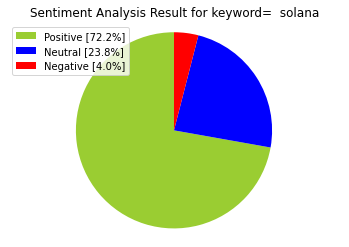

In [8]:
#Creating PieCart
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword=  "+keyword+"" )
plt.axis('equal')
plt.show()

## Cleaning Tweets before further Sentiment Analysis

1. Remove duplicated tweets
2. Create a new DataFrame (tw_list) and a new feature (text), then clean text of RTs, links, and punctuation using lambda function
3. Convert to lowercase

In [9]:
# Use the drop_duplicates function to remove dupicate tweets from the list.
tweet_list.drop_duplicates(inplace = True)

In [10]:
# Review the list of tweets, noting the number of duplicated tweets removed.
tweet_list

,0
0,@Sol_Hachiko @SirBuddy6 \n@Olivet1199 \n@Delig...
1,RT @Puppy_Solana: 🐶 To celebrate our launch on...
2,@joscarly303 https://t.co/zpJ8w818qh is First ...
3,"Check @shibafamily_nft, 2nd sale from Shiba Fa..."
4,@kitty_solana Good project sir @Ilhamarifsetiy...
...,...
489,@borksolana This project seems like an amazing...
490,"RT @NinthPlanetNFT: We are giving away 9,999 $..."
497,RT @Tepeecrew: They are coming… 🔥🔥🔥 Are you re...
498,RT @tylerposey627: @solanaDoggy @aj_timi \n@iy...


In [11]:
# Creating new DataFrame and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

# Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,@Sol_Hachiko @SirBuddy6 \n@Olivet1199 \n@Delig...,hachiko solana airdrop memecoin
1,RT @Puppy_Solana: 🐶 To celebrate our launch on...,to celebrate our launch on 1st november we ...
2,@joscarly303 https://t.co/zpJ8w818qh is First ...,is first metaverse vr ar farming game on s...
3,"Check @shibafamily_nft, 2nd sale from Shiba Fa...",check nft 2nd sale from shiba family collec...
4,@kitty_solana Good project sir @Ilhamarifsetiy...,solana good project sir
5,RT @GIFTO_io: An NFT without gifts was unthink...,an nft without gifts was unthinkable we re c...
6,RT @solana_daily: Love a lambo ⁉️\n\nIntroduci...,love a lambo introducing your lamborg...
7,@kitty_solana Good luck with this project in t...,solana good luck with this project in the fu...
8,RT @solchampions: WE ARE LIVE BOYS! SUMMON YOU...,we are live boys summon your champion now ...
9,@dogey_inu @VitalikButerin #BTC \n#ETH #coinex...,inu btc eth coinex safemoon vra coi...


## Sentiment Analysis

In [12]:
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp

tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,@Sol_Hachiko @SirBuddy6 \n@Olivet1199 \n@Delig...,hachiko solana airdrop memecoin,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,RT @Puppy_Solana: 🐶 To celebrate our launch on...,to celebrate our launch on 1st november we ...,0.175000,0.316667,positive,0.000,0.766,0.234,0.7003
2,@joscarly303 https://t.co/zpJ8w818qh is First ...,is first metaverse vr ar farming game on s...,-0.004545,0.411111,neutral,0.000,1.000,0.000,0.0000
3,"Check @shibafamily_nft, 2nd sale from Shiba Fa...",check nft 2nd sale from shiba family collec...,0.375000,0.475000,positive,0.099,0.751,0.150,0.2732
4,@kitty_solana Good project sir @Ilhamarifsetiy...,solana good project sir,0.700000,0.600000,positive,0.000,0.508,0.492,0.4404
5,RT @GIFTO_io: An NFT without gifts was unthink...,an nft without gifts was unthinkable we re c...,-0.025000,0.450000,neutral,0.000,1.000,0.000,0.0000
6,RT @solana_daily: Love a lambo ⁉️\n\nIntroduci...,love a lambo introducing your lamborg...,0.400000,0.750000,positive,0.000,0.629,0.371,0.7579
7,@kitty_solana Good luck with this project in t...,solana good luck with this project in the fu...,0.536667,0.501667,positive,0.000,0.564,0.436,0.8910
8,RT @solchampions: WE ARE LIVE BOYS! SUMMON YOU...,we are live boys summon your champion now ...,0.136364,0.500000,positive,0.000,0.755,0.245,0.5994
9,@dogey_inu @VitalikButerin #BTC \n#ETH #coinex...,inu btc eth coinex safemoon vra coi...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000


### Sentiment-Based Grouping

In [13]:
# Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [14]:
# Function for count_values_in single columns
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [15]:
# Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
positive,196,65.12
neutral,91,30.23
negative,14,4.65


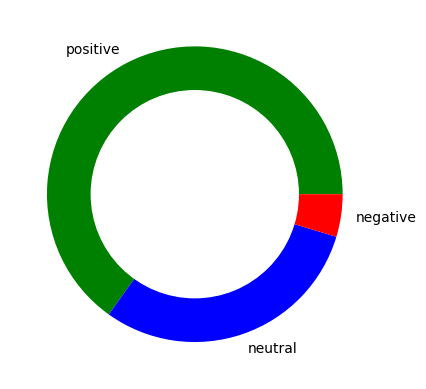

In [16]:
# Create data for Pie Chart
pc = count_values_in_column(tw_list,"sentiment")
names= pc.index
size=pc["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Visualization Sentiments with WordCloud

This helps us get an understanding of which words are used most in the tweets we are analyzing.

Define a WordCloud function to be used several times (for all tweets, positive tweets, negative tweets, and neutral tweets). Save the WordCloud image to file for later upload to GitHub repository.

In [17]:
# Function to Create Wordcloud
def create_wordcloud(text):
    mask = np.array(Image.open("blk_dollar.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=350,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


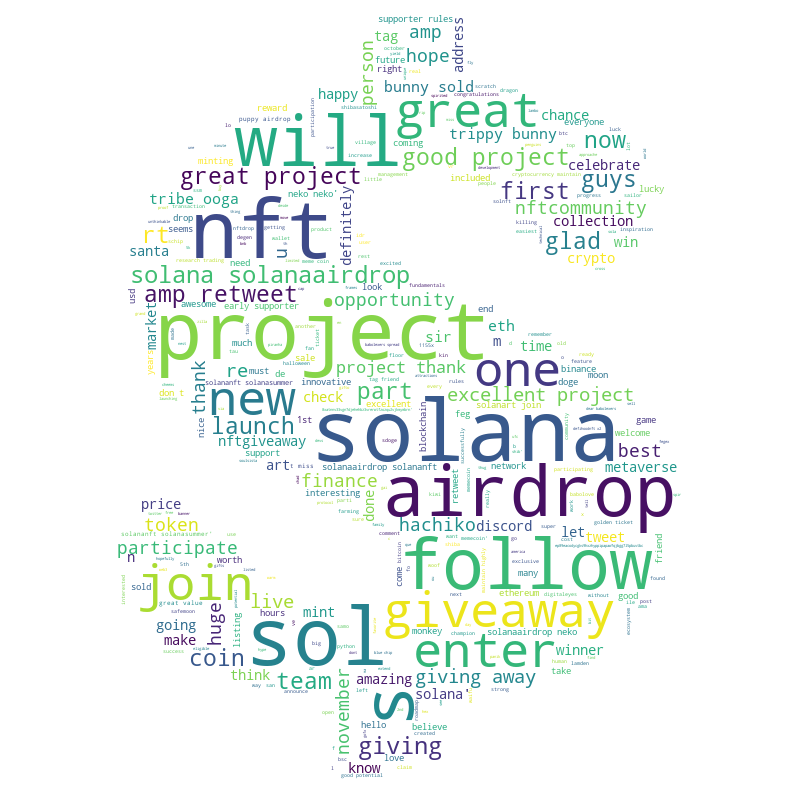

In [18]:
# Creating wordcloud for all tweets
create_wordcloud(tw_list["text"].values)

Word Cloud Saved Successfully


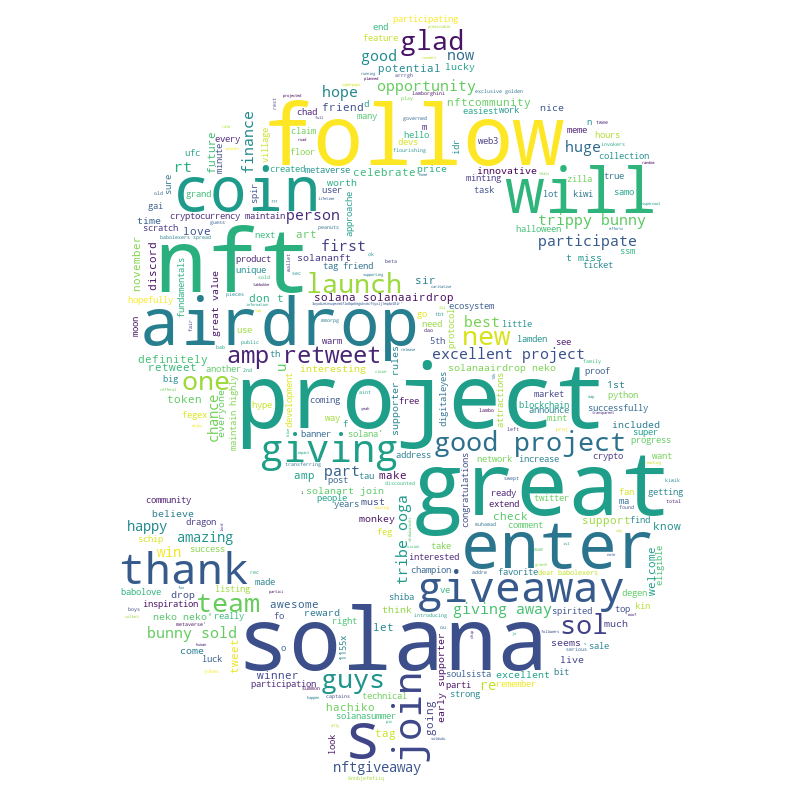

In [19]:
# Creating wordcloud for positive sentiment
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


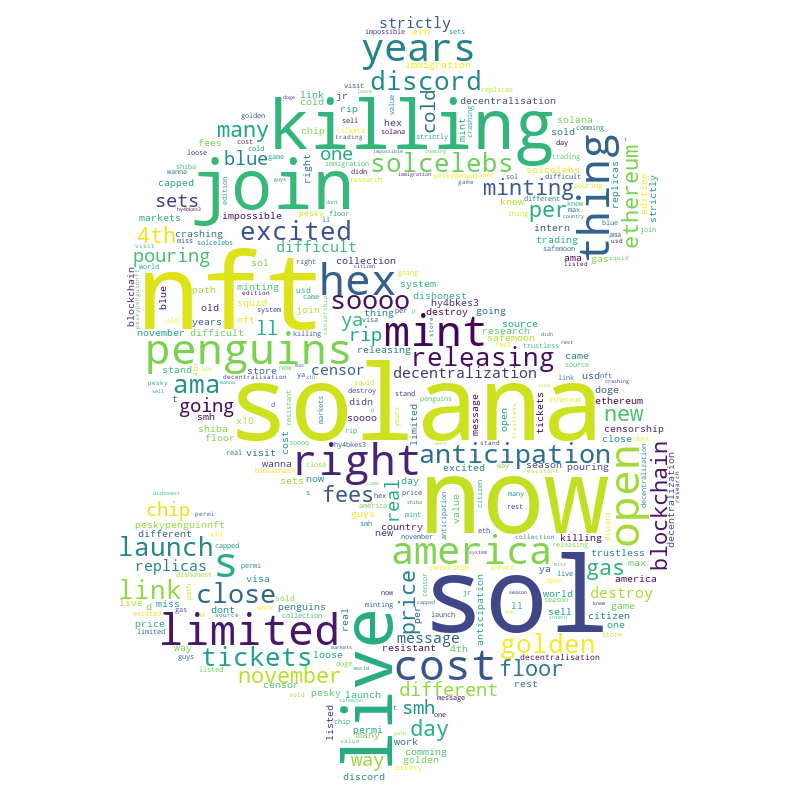

In [20]:
# Creating wordcloud for negative sentiment
create_wordcloud(tw_list_negative["text"].values)

Word Cloud Saved Successfully


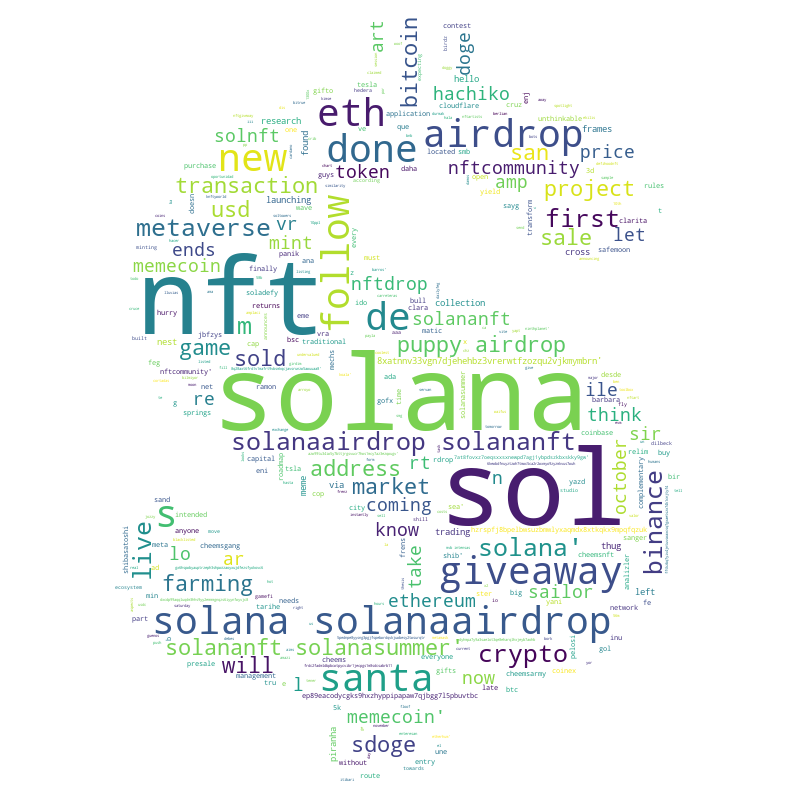

In [21]:
# Creating wordcloud for neutral sentiment
create_wordcloud(tw_list_neutral["text"].values)

### Calculate Tweet Length and Wordcount 

This helps us gain an understanding of the density of words and characters used in tweets based on different sentiment

In [22]:
# Calculating tweet's length and word count
tw_list['text_len'] = tw_list['text'].astype(str).apply(len)
tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))

In [23]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,105.21
neutral,77.81
positive,99.64


In [24]:
round(pd.DataFrame(tw_list.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,18.21
neutral,10.38
positive,16.25


### Pre-Processing

In [25]:
# Removing Punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

tw_list['punct'] = tw_list['text'].apply(lambda x: remove_punct(x))

**"Tokenization"** involves splitting sentences and words from the body of the text. One can think of "tokens" as parts, like a word is a "token" in a sentence, and a sentence is a "token" in a paragraph.

In [26]:
# Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))

The process of converting data to something a computer an understand is referred to as pre-processing. One of the major form of pre-processing is to filter out useless data. In natural language processing (NLP), useless words (data) are referred to as **stopwords**.

A **stopword** is a commonly used word (such as "a," "an," "the," "in") that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. We would not want these words to take up space in our database or take up valuable processing time. So, we remove them by storing a list of words that you consider as stopwords. Here, we use **NLTK** (Natural Language ToolKit), which has a list of stopwords in 16 different languages.

In [27]:
# Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))

### Stemming

Stemming is the process of producing morphological variants of a root word. A stemming algorithm, for example, reduces the words "chocolates", "chocolatey", "choco" to the root word "chocolate", and "retrieval", "retrieves", "retrieved" reduce to the stem "retrieve." This allows us to consider all words that come from the same root word as the same word.

In [28]:
# Applying Stemmer
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))

~ Test Out: Lemmatization ~

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming, but it brings context to the words, linking words with similar meaning to one word.

side note: I read that lemmatization is actually preferred over stemming lemmatization does morphological analysis of the words... try it out later?

In [29]:
#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [30]:
tw_list.head()

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed
0,@Sol_Hachiko @SirBuddy6 \n@Olivet1199 \n@Delig...,hachiko solana airdrop memecoin,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000,46,4,hachiko solana airdrop memecoin,"[, hachiko, solana, airdrop, memecoin]","[, hachiko, solana, airdrop, memecoin]","[, hachiko, solana, airdrop, memecoin]"
1,RT @Puppy_Solana: 🐶 To celebrate our launch on...,to celebrate our launch on 1st november we ...,0.175000,0.316667,positive,0.000,0.766,0.234,0.7003,123,23,to celebrate our launch on st november we a...,"[, to, celebrate, our, launch, on, st, novembe...","[, celebrate, launch, st, november, first, air...","[, celebr, launch, st, novemb, first, airdrop,..."
2,@joscarly303 https://t.co/zpJ8w818qh is First ...,is first metaverse vr ar farming game on s...,-0.004545,0.411111,neutral,0.000,1.000,0.000,0.0000,84,16,is first metaverse vr ar farming game on s...,"[, is, first, metaverse, vr, ar, farming, game...","[, first, metaverse, vr, ar, farming, game, so...","[, first, metavers, vr, ar, farm, game, solana..."
3,"Check @shibafamily_nft, 2nd sale from Shiba Fa...",check nft 2nd sale from shiba family collec...,0.375000,0.475000,positive,0.099,0.751,0.150,0.2732,107,18,check nft nd sale from shiba family collect...,"[check, nft, nd, sale, from, shiba, family, co...","[check, nft, nd, sale, shiba, family, collecti...","[check, nft, nd, sale, shiba, famili, collect,..."
4,@kitty_solana Good project sir @Ilhamarifsetiy...,solana good project sir,0.700000,0.600000,positive,0.000,0.508,0.492,0.4404,31,4,solana good project sir,"[, solana, good, project, sir, ]","[, solana, good, project, sir, ]","[, solana, good, project, sir, ]"


### Using CountVectorizer to Extract Features from Text

CountVectorizer is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple texts and we wish to convert each word in each text into vectors for use in further text analysis.

CountVectorizer creates a matrix where each unique word is represented by a column in the matrix and each text sample is a row. The value of each cell is nothing but the count of the word in that particular text sample.

In [31]:
# Applying CountVectorizer to see all unique words as new features
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list['text'])
print('The {} Tweets analyzed have {} unique words'.format(countVector.shape[0], countVector.shape[1]))
#print(countVectorizer.get_feature_names())

The 301 Tweets analyzed have 963 unique words


In [32]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

,,aaa,accord,activ,actual,ad,ada,addr,address,adopt,...,yapt,yazd,ycgnklkybpqejozphxgjfrhsfaautnr,yeah,year,yg,yield,yor,z,zilla
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Most Used Words

Use the sort_values function and organize in descending order to see which words are used the most in the Tweets analyzed.

In [33]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
solana,139
project,111
nft,54
great,35
airdrop,32
sol,32
like,29
follow,29
give,26
good,24


### Building N-gram Language Models

**Language Modelling** is a process of determining the probability of any sequence of words. **N-gram modelling** is an example of **Statistical Language Modelling**, the development of probabilistic models that are able to predict the next word in the sequence given the words that precede. An alternative to this is Neural Language Modelling which uses neural network methods (an example of this is word embeddings).

* **N-gram** can be defined as the contiguous sequence of n items from a given sample of text or speech. The items can be letters, words, or base pairs according to the application. The n-grams are typically collected from a text or speech corpus (a long dataset).

This helps us predict the most probable words that might follow a given sequence.

In [34]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
#n2_bigram
n2_bigrams = get_top_n_gram(tw_list['text'],(2,2),20)

n2_bigrams

[('solana solanaairdrop', 16),
 ('good project', 14),
 ('000 000', 14),
 ('like amp', 13),
 ('amp retweet', 11),
 ('excellent project', 11),
 ('great project', 11),
 ('giving away', 10),
 ('enters airdrop', 9),
 ('solananft solanasummer', 8),
 ('coins person', 8),
 ('person enters', 8),
 ('giving 000', 8),
 ('project solana', 8),
 ('trippy bunny', 8),
 ('join tribe', 8),
 ('tribe ooga', 8),
 ('participate like', 7),
 ('solana good', 6),
 ('airdrop participate', 6)]

In [36]:
#n3_trigram
n3_trigrams = get_top_n_gram(tw_list['text'],(3,3),20)

n3_trigrams

[('like amp retweet', 11),
 ('coins person enters', 8),
 ('person enters airdrop', 8),
 ('giving 000 000', 8),
 ('join tribe ooga', 8),
 ('participate like amp', 7),
 ('enters airdrop participate', 6),
 ('airdrop participate like', 6),
 ('solana solanaairdrop solananft', 6),
 ('solanaairdrop solananft solanasummer', 6),
 ('amp retweet tweet', 5),
 ('solana solanaairdrop neko', 5),
 ('solanaairdrop neko neko', 5),
 ('project glad project', 5),
 ('solanart join tribe', 5),
 ('doing airdrop early', 4),
 ('airdrop early supporter', 4),
 ('early supporter rules', 4),
 ('having great value', 4),
 ('great value cryptocurrency', 4)]